In [3]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
import numpy as np
import csv

import plot_utils
from util import INST_NAME_ALIASES, binomial_confidence_interval, load_in_data
from scipy.stats import mannwhitneyu, ks_2samp, chisquare, chi2_contingency, ttest_ind, ranksums

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

%matplotlib inline

In [4]:
respondents_zip = pd.read_csv('../data/coded_data/data_linked.csv')

### Given your parents have a PhD, what's the likelihood that you will be faculty?

In [5]:
prof_dist = respondents_zip['parents_highest_edu_coded'].value_counts()
is_prof = [prof_dist[edu_bin].values.sum() for edu_bin in [
    ["Elementary: 0-8 years"], ['High school: 1-3 years'], ['High school: 4 years'],
    ['College: 1-3 years'], ['College: 4+ years'], ["Master's or professional degree"], ['Doctoral degree']]]

In [6]:
# Using estimates of educational attainment closest to when faculty were born
is_not_prof = [respondents_zip[edu_bin].values.sum() for edu_bin in [
    ['US_elem_1st-4th', 'US_elem_5th-6th', 'US_elem_7-8th'], ['US_hs_9th', 'US_hs_10th', 'US_hs_11th'], 
    ['US_hs_graduate'], ['US_college_some', 'US_associate_occupational', 'US_associate_academic'], 
    ['US_bachelors'], ['US_masters', 'US_professional_degree'], ['US_doctorate_degree']]]

In [7]:
# Using estimates of parents eductaion levels among doctoral recipients 
is_phd = [respondents_zip[edu_bin].values.sum() for edu_bin in [
    ['NSF_SED_high_school_or_less'], ['NSF_SED_some_college'], ["NSF_SED_bachelor's_degree"], 
    ["NSF_SED_master's_degree", 'NSF_SED_professional_degree'], ['NSF_SED_research_doctoral_degree']]]
print(is_phd)
print(['HS or less'], ['< College'], ["College"], ['Masters + professional'], ['PhD'])
print(['%.1f' % x for x in (100.*np.array(is_phd))/sum(is_phd)])

[201478.59999999998, 111754.69999999998, 184255.8, 207439.90000000002, 94222.1]
['HS or less'] ['< College'] ['College'] ['Masters + professional'] ['PhD']
['25.2', '14.0', '23.1', '26.0', '11.8']


In [8]:
education_prior = pd.DataFrame([
    is_prof/sum(is_prof), 
    is_not_prof/sum(is_not_prof)],
    index = ['All Professors', 'U.S. Population'],     
    columns = ['Elementary', '< HS', 'HS', '< College', 'College', 'Masters', 'PhD'])

print(education_prior.applymap(lambda x: x*100).to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Elementary &  < HS &   HS &  < College &  College &  Masters &  PhD \\
\midrule
All Professors  &         2.6 &   2.9 & 13.7 &        9.5 &     19.5 &     29.6 & 22.2 \\
U.S. Population &         8.7 &  10.5 & 35.6 &       23.1 &     14.6 &      6.5 &  0.9 \\
\bottomrule
\end{tabular}



$$P(\text{is faculty}|\text{PhD parents}) = \frac{P(\text{PhD parents}|\text{is faculty})\cdot P(\text{is faculty})}{ P(\text{PhD parents})}$$

$𝑃(\text{PhD parents}|\text{is faculty})$ and $P(\text{PhD parents})$ are given above. The former being the percentage of faculty that report a parent having earned PhD, and the latter being the percentage of the U.S. adult population earning a PhD.

The prior $P(\text{is faculty})$ is the proportion of the adult workforce working as a faculty member. Let's import data from the BLS on this. For simplicity, we will look to estimates in the year 2000 -- average year of faculty TT start in our survey.

In [9]:
respondents_zip['Tenure Track Year'].mean()

2000.3714326484019

In [10]:
bls_data = pd.read_excel('../data/bls_occupation/national_2000_dl.xls', skiprows=38)
faculty_occ_code = r'25-1.*'

In [11]:
bls_data.head()

,occ_code,occ_titl,group,tot_emp,emp_prse,h_mean,a_mean,mean_prse,h_wpct10,h_wpct25,h_median,h_wpct75,h_wpct90,a_wpct10,a_wpct25,a_median,a_wpct75,a_wpct90,annual,year
0,11-0000,Management Occupations,major,7782680,0.3,32.78,68190,0.2,14.05,19.95,29.47,42.80,63.80,29220,41500,61310,89020,132710,NaN,2000
1,11-1011,Chief Executives,NaN,519890,0.9,50.30,104630,0.5,22.30,34.99,54.72,#,#,46390,72780,113810,#,#,NaN,2000
2,11-1021,General and Operations Managers,NaN,2221590,0.5,33.76,70220,0.3,14.16,19.65,29.41,45.01,#,29450,40880,61160,93610,#,NaN,2000
3,11-1031,Legislators,NaN,52750,2.8,13.29,27650,1.9,5.56,6.03,6.78,16.69,30.22,11560,12530,14110,34720,62860,NaN,2000
4,11-2011,Advertising and Promotions Managers,NaN,93420,1.8,29.93,62260,1.1,13.39,17.48,25.66,39.13,57.36,27840,36370,53360,81400,119310,NaN,2000


In [12]:
print(list(bls_data[bls_data.occ_code.str.contains(faculty_occ_code)]['occ_titl']))

['Business Teachers, Postsecondary', 'Computer Science Teachers, Postsecondary', 'Mathematical Science Teachers, Postsecondary', 'Architecture Teachers, Postsecondary', 'Engineering Teachers, Postsecondary', 'Agricultural Sciences Teachers, Postsecondary', 'Biological Science Teachers, Postsecondary', 'Forestry and Conservation Science Teachers, Postsecondary', 'Atmospheric, Earth, Marine, and Space Sciences Teachers, Postsecondary', 'Chemistry Teachers, Postsecondary', 'Environmental Science Teachers, Postsecondary', 'Physics Teachers, Postsecondary', 'Anthropology and Archeology Teachers, Postsecondary', 'Area, Ethnic, and Cultural Studies Teachers, Postsecondary', 'Economics Teachers, Postsecondary', 'Geography Teachers, Postsecondary', 'Political Science Teachers, Postsecondary', 'Psychology Teachers, Postsecondary', 'Sociology Teachers, Postsecondary', 'Health Specialties Teachers, Postsecondary', 'Nursing Instructors and Teachers, Postsecondary', 'Education Teachers, Postsecondar

In [13]:
postsecondary_total = bls_data[bls_data.occ_code.str.contains(faculty_occ_code)]['tot_emp'].sum()
total_employment = bls_data['tot_emp'].sum()
print(postsecondary_total, total_employment)

940440 250760730


In [14]:
prob_faculty = postsecondary_total/total_employment
prob_phd_given_faculty = education_prior['PhD']['All Professors']
prob_phd_adults = education_prior['PhD']['U.S. Population']
print(prob_phd_given_faculty, prob_faculty, prob_phd_adults)

0.2224996532112637 0.0037503479910909496 0.008806816756628985


In [15]:
prob_faculty_given_phd = (prob_phd_given_faculty*prob_faculty)/prob_phd_adults
print(prob_faculty_given_phd)

0.09475059496510989


## What's the probability of Black and White people of becoming faculty?

$$P(\text{is faculty}|\text{Black}) = Pr(\text{is faculty}|\text{PhD parents}) \cdot Pr(\text{PhD parents}|\text{Black})$$

Just above, we calculated $P(\text{is faculty}|\text{PhD parents})$. In order to calculate the probability of Black people becoming professors [under this very simple model], we need data on $Pr(\text{PhD parents}|\text{Black})$. Let's consider what the percentage of Black adults holding PhD's looks like over time.

In [16]:
census_edu_by_race = pd.read_excel('../data/us_census_edu/census/by_race/prob_doctoral_1993_2019.xlsx')
census_edu_by_race.rename({'Year': 'year', 'Black %': 'perc_black', 'Hispanic %': 'perc_hisp', 
                           'White %': 'perc_white', 'Non-Hispanic White %': 'perc_nonhisp', 
                           'Asian %': 'perc_asian'}, axis=1, inplace=True)
census_edu_by_race

,year,White N,perc_white,Non-Hispanic White N,perc_nonhisp,Black N,perc_black,Asian N,perc_asian,Hispanic N,perc_hisp
0,1993,1249,0.9,NaN,NaN,56.0000,0.3,NaN,NaN,35.0000,0.3
1,1994,1450,1.0,NaN,NaN,59.0000,0.3,NaN,NaN,58.0000,0.4
2,1995,1447,1.0,NaN,NaN,88.0000,0.5,NaN,NaN,47.0000,0.3
3,1996,1378,1.0,NaN,NaN,75.0000,0.4,NaN,NaN,54.0000,0.4
4,1997,1547,1.1,NaN,NaN,65.0000,0.3,NaN,NaN,73.0000,0.5
5,1998,1639,1.1,NaN,NaN,73.0000,0.4,NaN,NaN,80.0000,0.5
6,1999,1784,1.2,1708.0,1.3,62.0000,0.3,179.0000,2.8,79.0000,0.5
7,2000,1734,1.2,1656.0,1.3,72.0000,0.4,207.0000,3.1,84.0000,0.5
8,2001,1775,1.2,1715.0,1.3,102.0000,0.5,253.0000,3.1,68.0000,0.4
9,2002,1828,1.2,1767.0,1.3,109.0000,0.5,235.0000,3.0,68.0000,0.3


In [17]:
edu_black_res = smf.ols('perc_black ~ year', data=census_edu_by_race).fit()
# plt.scatter(census_edu_by_race['year'], census_edu_by_race['perc_black'])
# plt.plot(census_edu_by_race['year'], edu_black_res.predict())

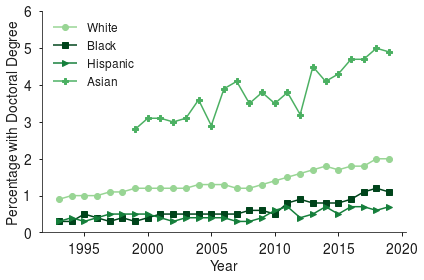

In [18]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE)

category_colors = plt.get_cmap('Greens')(np.linspace(0.4, 1, 4))[::-1]
plt.plot(census_edu_by_race['year'], census_edu_by_race['perc_white'], marker='o', label='White', 
         color=category_colors[3])
plt.plot(census_edu_by_race['year'], census_edu_by_race['perc_black'], marker='s', label='Black',
         color=category_colors[0])
plt.plot(census_edu_by_race['year'], census_edu_by_race['perc_hisp'], marker='>', label='Hispanic',
         color=category_colors[1])
plt.plot(census_edu_by_race['year'], census_edu_by_race['perc_asian'], marker='P', label='Asian',
         color=category_colors[2])
# plt.plot(census_edu_by_race['year'], census_edu_by_race['perc_nonhisp'], marker='P', label='Non-Hispanic',
#          color=category_colors[2])

ax.set_ylabel('Percentage with Doctoral Degree', fontsize=plot_utils.LABEL_SIZE)
ax.set_xlabel('Year', fontsize=plot_utils.LABEL_SIZE)
plt.legend(frameon=False, fontsize=plot_utils.LEGEND_SIZE, loc='upper left')

# plt.xlim(1998, 2019)
plt.ylim(0, 6)
plt.yticks([0, 1, 2, 3, 4, 5, 6])
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/percentage_adults_with_phd.pdf', dpi=500)

[1994.0, 1997.0, 2000.0, 2003.0, 2006.0, 2009.0, 2012.0, 2015.0, 2018.0]


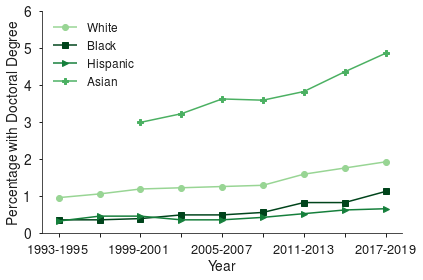

In [19]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE)

year_bins = [census_edu_by_race['year'][n:n+3].mean() for n in range(0, len(census_edu_by_race['year']), 3)]
print(year_bins)
perc_white_bins = [census_edu_by_race['perc_white'][n:n+3].mean() for n in range(0, len(census_edu_by_race['perc_white']), 3)]
perc_black_bins = [census_edu_by_race['perc_black'][n:n+3].mean() for n in range(0, len(census_edu_by_race['perc_black']), 3)]
perc_hisp_bins = [census_edu_by_race['perc_hisp'][n:n+3].mean() for n in range(0, len(census_edu_by_race['perc_hisp']), 3)]
perc_asian_bins = [census_edu_by_race['perc_asian'][n:n+3].mean() for n in range(0, len(census_edu_by_race['perc_asian']), 3)]

category_colors = plt.get_cmap('Greens')(np.linspace(0.4, 1, 4))[::-1]
plt.plot(year_bins, perc_white_bins, marker='o', label='White', color=category_colors[3])
plt.plot(year_bins, perc_black_bins, marker='s', label='Black', color=category_colors[0])
plt.plot(year_bins, perc_hisp_bins, marker='>', label='Hispanic', color=category_colors[1])
plt.plot(year_bins, perc_asian_bins, marker='P', label='Asian', color=category_colors[2])
# plt.plot(census_edu_by_race['year'], census_edu_by_race['perc_nonhisp'], marker='P', label='Non-Hispanic',
#          color=category_colors[2])

ax.set_ylabel('Percentage with Doctoral Degree', fontsize=plot_utils.LABEL_SIZE)
ax.set_xlabel('Year', fontsize=plot_utils.LABEL_SIZE)
plt.legend(frameon=False, fontsize=plot_utils.LEGEND_SIZE, loc='upper left')

# plt.xlim(1998, 2019)
plt.ylim(0, 6)
plt.yticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticks([1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015, 2018])
plot_utils.finalize(ax)

ax.set_xticklabels(
    ["1993-1995", "", "1999-2001", "", "2005-2007", "", "2011-2013", "", "2017-2019"], fontsize=13)
# ax.set_xticklabels(
#     ["'93-95", "'96-98", "'99-01", "'02-04", "'05-07", "'08-10", "'11-13", "'14-16", "'17-19"], fontsize=13)
plt.tight_layout()
plt.savefig('../plots/percentage_adults_with_phd_smoothing.pdf', dpi=500)

To be faculty with a PhD parent, we need to the compare faculty estimates to the educational attainment of adults close to the year faculty were born. As in, in order for SES to influence the demographics of the professoriate, we need to wait for their child to get a PhD and become faculty. 

In [20]:
delta = round((respondents_zip['Tenure Track Year']-respondents_zip['age_coded']).mean())
(respondents_zip['Tenure Track Year']-respondents_zip['age_coded']).describe()

count    6974.000000
mean       33.457126
std         5.225212
min        21.000000
25%        30.000000
50%        33.000000
75%        36.000000
max        70.000000
dtype: float64

The probability that a Black, White, or Hispanic person is faculty at a single point in time:

In [21]:
prob_phd_given_black = (census_edu_by_race[census_edu_by_race.year == 1993]['perc_black']/100).values[0]
print(100*prob_phd_given_black, 100*prob_faculty_given_phd*prob_phd_given_black)

prob_phd_given_hisp = (census_edu_by_race[census_edu_by_race.year == 1993]['perc_hisp']/100).values[0]
print(100*prob_phd_given_hisp, 100*prob_faculty_given_phd*prob_phd_given_hisp)

prob_phd_given_white = (census_edu_by_race[census_edu_by_race.year == 1993]['perc_white']/100).values[0]
print(100*prob_phd_given_white, 100*prob_faculty_given_phd*prob_phd_given_white)

0.3 0.028425178489532965
0.3 0.028425178489532965
0.9000000000000001 0.08527553546859891


In [22]:
def prob_faculty_given_black(year):
    parent_year = (year - delta)
#     if parent_year < census_edu_by_race['year'].min():
#         parent_year = census_edu_by_race['year'].min()
    
    # prob_phd_given_black = census_edu_by_race[census_edu_by_race['year'] == parent_year]['perc_black']
    prob_phd_given_black = edu_black_res.predict({'year': parent_year})
    print(year, parent_year, prob_phd_given_black)
    return float(prob_faculty_given_phd*prob_phd_given_black)

## Forecasting percentage of Black adults earning PhDs

In [23]:
us_census_race = pd.read_csv('../data/us_census_race/census_race_by_decade.csv')
us_census_race = us_census_race[us_census_race.Year < 2019]
us_census_race.rename({'Total Population':'pop', 'Year': 'year', '% Black': 'perc_black', 
                       '% Hisp': 'perc_hisp', '% White': 'perc_white'}, axis=1, inplace=True)
us_census_race[['perc_black', 'perc_hisp', 'perc_white']] = us_census_race[['perc_black', 'perc_hisp', 'perc_white']]/100.0
us_census_race

,year,perc_black,perc_hisp,perc_white,% Native,% Asian,% Other,% Multiple,pop,Source
1,2010,0.126,0.163,0.724,1.0,4.8,6.2,2.9,308745538,Overview of Race and Hispanic Origin: 2010
2,2000,0.123,0.125,0.751,1.0,3.6,5.5,2.4,281421906,Overview of Race and Hispanic Origin: 2010
3,1990,0.121,0.090,0.803,0.8,2.9,3.9,NaN,248709873,HISTORICAL CENSUS STATISTICS ON POPULATION TOT...
4,1980,0.117,0.064,0.831,0.6,1.5,3.0,NaN,226545805,HISTORICAL CENSUS STATISTICS ON POPULATION TOT...
5,1970,0.111,0.045,0.875,0.4,0.8,0.3,NaN,203211926,HISTORICAL CENSUS STATISTICS ON POPULATION TOT...
6,1960,0.105,NaN,0.886,0.3,0.5,NaN,NaN,179323175,HISTORICAL CENSUS STATISTICS ON POPULATION TOT...


In [24]:
pop_res = smf.ols('pop ~ year', data=us_census_race).fit()
pop_black = smf.ols('perc_black ~ year', data=us_census_race).fit()

In [25]:
total_faculty = pd.read_csv('../data/bls_occupation/postsecondary_empl_over_time.csv')
fac_res = smf.ols('postsecondary_emp ~ year', data=total_faculty).fit()

In [26]:
faculty_race = pd.read_csv('../data/nces_faculty/racial_demographics.csv')
faculty_race['prop_black'] = faculty_race['black']/faculty_race['total']

In [27]:
years = range(1990, 2100, 10)
perc_black_faculty = []
perc_black_us = []
for y in years:
    data = {'year': y}
    faculty_given_black = prob_faculty_given_black(y)
    estimated_total_pop = float(pop_res.predict(data))
    estimated_perc_black = float(pop_black.predict(data))
    estimated_fac = float(fac_res.predict(data))

    perc_black_faculty.append(faculty_given_black*estimated_perc_black*estimated_total_pop/estimated_fac)
    perc_black_us.append(100*estimated_perc_black)

1990 1957 0   -0.854701
dtype: float64
2000 1967 0   -0.555556
dtype: float64
2010 1977 0   -0.25641
dtype: float64
2020 1987 0    0.042735
dtype: float64
2030 1997 0    0.34188
dtype: float64
2040 2007 0    0.641026
dtype: float64
2050 2017 0    0.940171
dtype: float64
2060 2027 0    1.239316
dtype: float64
2070 2037 0    1.538462
dtype: float64
2080 2047 0    1.837607
dtype: float64
2090 2057 0    2.136752
dtype: float64


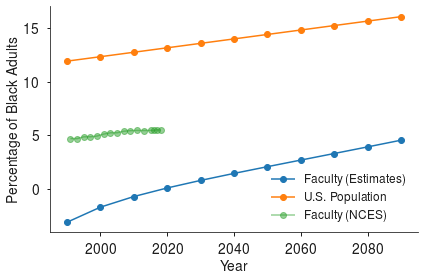

In [28]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE)
plt.plot(years, perc_black_faculty, marker='o', label='Faculty (Estimates)')
plt.plot(years, perc_black_us, marker='o', label='U.S. Population')
plt.plot(faculty_race['year'], 100*faculty_race['prop_black'], label='Faculty (NCES)', marker='o', alpha=0.5)
plt.xlabel('Year', fontsize=plot_utils.LABEL_SIZE)
plt.ylabel('Percentage of Black Adults', fontsize=plot_utils.LABEL_SIZE)
plt.legend(frameon=False, fontsize=plot_utils.LEGEND_SIZE)
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/bad_model.png', dpi=500)